# Respiratory Disease Classification using LSTM
## Multi-class Classification (Healthy, COPD, Asthma)

Pipeline lengkap untuk training model LSTM menggunakan MFCC features dari audio cough dan vowel.

**Classes:**
- **Class 0: Healthy**
- **Class 1: COPD** 
- **Class 2: Asthma**

## Pipeline:
1. Load data dari dataclean_cough dan dataclean_vowel
2. Extract MFCC features real-time dari audio files
3. Split berdasarkan train.csv dan test.csv dengan validation split
4. Training SINGLE unified model dengan attention mechanism
5. Evaluasi dengan metrics: Accuracy, F1, Recall, Precision, Confusion Matrix
6. Prediction pada test set
7. Save hasil ke CSV

## 1. Import Libraries

In [40]:
import os
import json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import librosa
from pathlib import Path
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    fbeta_score, confusion_matrix, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

Using device: cuda


## 2. Configuration

In [41]:
class Config:
    # Paths
    BASE_PATH = Path('/mnt/ml_storage/Final_Project/SOURCE2')
    COUGH_PATH = BASE_PATH / 'dataclean_cough_1'
    VOWEL_PATH = BASE_PATH / 'dataclean_vowel_1'
    TRAIN_CSV = BASE_PATH / 'train.csv'
    TEST_CSV = BASE_PATH / 'test.csv'
    MODEL_DIR = BASE_PATH / 'models'
    
    # Audio parameters - IMPROVED
    SAMPLE_RATE = 16000
    DURATION = 2.0  # Increased from 1.0 to capture more context
    N_FFT = 2048  # Increased for better frequency resolution
    HOP_LENGTH = 512  # Adjusted for new N_FFT
    WIN_LENGTH = 2048
    N_MFCC = 20  # Increased from 13 for richer features
    N_MELS = 64  # Increased from 40
    
    # Model parameters - IMPROVED
    INPUT_SIZE = 60  # 20 MFCC + 20 Delta + 20 Delta-Delta
    HIDDEN_SIZE = 128  # Reduced to prevent overfitting
    NUM_LAYERS = 2
    OUTPUT_SIZE = 3  # 3 classes: Healthy(0), COPD(1), Asthma(2)
    DROPOUT = 0.4  # Increased dropout
    BIDIRECTIONAL = True
    
    # Training parameters - IMPROVED
    BATCH_SIZE = 16  # Smaller batch for better generalization
    LEARNING_RATE = 0.0005  # Slightly lower for stability
    NUM_EPOCHS = 150
    VAL_SPLIT = 0.2
    PATIENCE = 25  # More patience
    GRADIENT_CLIP = 1.0
    WEIGHT_DECAY = 1e-3  # Stronger regularization
    
    # Data augmentation
    USE_AUGMENTATION = True
    MIXUP_ALPHA = 0.2  # Mixup augmentation strength
    
    # Audio combination mode
    COMBINE_MODE = "concat"  # Options: "concat", "average", "cough_only", "vowel_only"
    
config = Config()

# Create model directory
config.MODEL_DIR.mkdir(exist_ok=True)

print("Configuration (IMPROVED):")
print(f"  Sample Rate: {config.SAMPLE_RATE} Hz")
print(f"  Duration: {config.DURATION} seconds")
print(f"  N_MFCC: {config.N_MFCC}")
print(f"  Input Features: {config.INPUT_SIZE}")
print(f"  Hidden Size: {config.HIDDEN_SIZE}")
print(f"  Output Classes: {config.OUTPUT_SIZE} (0=Healthy, 1=COPD, 2=Asthma)")
print(f"  Batch Size: {config.BATCH_SIZE}")
print(f"  Learning Rate: {config.LEARNING_RATE}")
print(f"  Epochs: {config.NUM_EPOCHS}")
print(f"  Dropout: {config.DROPOUT}")
print(f"  Weight Decay: {config.WEIGHT_DECAY}")
print(f"  Augmentation: {config.USE_AUGMENTATION}")
print(f"  Combine Mode: {config.COMBINE_MODE}")

Configuration (IMPROVED):
  Sample Rate: 16000 Hz
  Duration: 2.0 seconds
  N_MFCC: 20
  Input Features: 60
  Hidden Size: 128
  Output Classes: 3 (0=Healthy, 1=COPD, 2=Asthma)
  Batch Size: 16
  Learning Rate: 0.0005
  Epochs: 150
  Dropout: 0.4
  Weight Decay: 0.001
  Augmentation: True
  Combine Mode: concat


## 3. Class Imbalance Handling

In [42]:
def compute_class_weights(labels, method='sqrt'):
    """
    Compute class weights for imbalanced dataset
    
    Methods:
    - 'balanced': weight = total_samples / (num_classes * class_count) 
    - 'sqrt': weight = sqrt(max_count / class_count) - softer weighting
    - 'none': equal weights for all classes
    """
    unique_classes, class_counts = np.unique(labels, return_counts=True)
    total_samples = len(labels)
    num_classes = len(unique_classes)
    
    if method == 'balanced':
        # Standard sklearn balanced weighting
        class_weights = total_samples / (num_classes * class_counts)
    elif method == 'sqrt':
        # Softer weighting using square root
        max_count = class_counts.max()
        class_weights = np.sqrt(max_count / class_counts)
    else:
        # No weighting
        class_weights = np.ones(num_classes)
    
    print(f"\nClass Imbalance Analysis (method='{method}'):")
    print(f"{'='*60}")
    print(f"{'Class':<15} {'Count':<10} {'Percentage':<15} {'Weight':<10}")
    print(f"{'-'*60}")
    
    class_names = ['Healthy', 'COPD', 'Asthma']
    for cls, count, weight in zip(unique_classes, class_counts, class_weights):
        percentage = count / total_samples * 100
        print(f"{class_names[int(cls)]:<15} {count:<10} {percentage:<15.2f} {weight:<10.4f}")
    
    print(f"{'='*60}")
    print(f"Weight ratio (max/min): {class_weights.max()/class_weights.min():.2f}x")
    
    return torch.FloatTensor(class_weights)


print("Class imbalance handling function defined!")

Class imbalance handling function defined!


## 4. Dataset Class

In [43]:
class RespiratoryDataset(Dataset):
    """Unified dataset that combines cough and vowel audio features"""
    
    def __init__(self, candidate_ids, labels, config, is_test=False, augment=False):
        """
        Args:
            candidate_ids: List of candidate IDs
            labels: List of labels (0: Healthy, 1: COPD, 2: Asthma) or None for test
            config: Configuration object
            is_test: whether this is test set (no labels)
            augment: whether to apply data augmentation (only for training)
        """
        self.candidate_ids = candidate_ids
        self.labels = labels
        self.config = config
        self.is_test = is_test
        self.augment = augment and not is_test  # Only augment training data
        self.cough_path = config.COUGH_PATH
        self.vowel_path = config.VOWEL_PATH
    
    def __len__(self):
        return len(self.candidate_ids)
    
    def _augment_audio(self, audio):
        """Apply random audio augmentations"""
        if not self.augment or np.random.random() > 0.5:
            return audio
        
        # Choose one augmentation randomly
        aug_type = np.random.choice(['noise', 'shift', 'speed', 'gain'])
        
        if aug_type == 'noise':
            # Add random noise
            noise_factor = np.random.uniform(0.001, 0.005)
            noise = np.random.randn(len(audio)) * noise_factor
            audio = audio + noise
            
        elif aug_type == 'shift':
            # Time shift
            shift_max = int(len(audio) * 0.1)
            shift = np.random.randint(-shift_max, shift_max)
            audio = np.roll(audio, shift)
            
        elif aug_type == 'speed':
            # Speed perturbation (subtle)
            speed_factor = np.random.uniform(0.95, 1.05)
            audio = librosa.effects.time_stretch(audio, rate=speed_factor)
            # Adjust length back
            target_len = int(self.config.SAMPLE_RATE * self.config.DURATION)
            if len(audio) > target_len:
                audio = audio[:target_len]
            else:
                audio = np.pad(audio, (0, target_len - len(audio)), mode='constant')
                
        elif aug_type == 'gain':
            # Random gain
            gain_factor = np.random.uniform(0.8, 1.2)
            audio = audio * gain_factor
        
        return audio
    
    def _load_and_extract_features(self, audio_path):
        """Load audio and extract MFCC features"""
        try:
            audio, sr = librosa.load(audio_path, sr=self.config.SAMPLE_RATE)
            
            # Segment to target duration
            target_samples = int(self.config.SAMPLE_RATE * self.config.DURATION)
            if len(audio) > target_samples:
                audio = audio[:target_samples]
            else:
                audio = np.pad(audio, (0, target_samples - len(audio)), mode='constant')
            
            # Apply augmentation (training only)
            if self.augment:
                audio = self._augment_audio(audio)
            
            # Extract MFCC with config parameters
            mfcc = librosa.feature.mfcc(
                y=audio,
                sr=self.config.SAMPLE_RATE,
                n_mfcc=self.config.N_MFCC,
                n_fft=self.config.N_FFT,
                hop_length=self.config.HOP_LENGTH,
                n_mels=self.config.N_MELS
            )
            
            # Extract delta and delta-delta
            delta = librosa.feature.delta(mfcc)
            delta_delta = librosa.feature.delta(mfcc, order=2)
            
            # Combine features (N_MFCC*3, n_frames)
            features = np.vstack([mfcc, delta, delta_delta])
            
            # Transpose to (n_frames, N_MFCC*3)
            features = features.T
            
            # Replace NaN and Inf with zeros
            features = np.nan_to_num(features, nan=0.0, posinf=0.0, neginf=0.0)
            
            # Clip extreme values
            features = np.clip(features, -1e6, 1e6)
            
            return features
            
        except Exception as e:
            print(f"Error loading {audio_path}: {str(e)}")
            # Return zero features on error - calculate expected frames
            expected_frames = int((self.config.SAMPLE_RATE * self.config.DURATION) / self.config.HOP_LENGTH) + 1
            return np.zeros((expected_frames, self.config.INPUT_SIZE))
    
    def __getitem__(self, idx):
        candidate_id = self.candidate_ids[idx]
        
        # Construct audio paths
        cough_audio_path = self.cough_path / candidate_id / 'cough.wav'
        vowel_audio_path = self.vowel_path / candidate_id / 'vowel.wav'
        
        # Load and extract features
        cough_features = self._load_and_extract_features(cough_audio_path)
        vowel_features = self._load_and_extract_features(vowel_audio_path)
        
        # Combine features based on mode
        if self.config.COMBINE_MODE == "concat":
            # Concatenate along feature dimension
            combined = np.concatenate([cough_features, vowel_features], axis=1)
        elif self.config.COMBINE_MODE == "average":
            # Average the features
            combined = (cough_features + vowel_features) / 2.0
        elif self.config.COMBINE_MODE == "cough_only":
            combined = cough_features
        elif self.config.COMBINE_MODE == "vowel_only":
            combined = vowel_features
        else:
            raise ValueError(f"Unknown combine_mode: {self.config.COMBINE_MODE}")
        
        # Convert to tensor
        audio_tensor = torch.FloatTensor(combined)
        
        if self.is_test:
            return audio_tensor, candidate_id
        else:
            label = torch.LongTensor([self.labels[idx]])[0]
            return audio_tensor, label, candidate_id


# Custom collate function for variable-length sequences
def collate_fn(batch):
    """Collate function to handle variable-length sequences"""
    if len(batch[0]) == 2:
        # Test set (audio, candidate_id)
        audio_features = [item[0] for item in batch]
        candidate_ids = [item[1] for item in batch]
        
        # Pad audio sequences
        audio_padded = nn.utils.rnn.pad_sequence(audio_features, batch_first=True)
        lengths = torch.LongTensor([len(x) for x in audio_features])
        
        return audio_padded, lengths, candidate_ids
    else:
        # Training set (audio, label, candidate_id)
        audio_features = [item[0] for item in batch]
        labels = torch.stack([item[1] for item in batch])
        candidate_ids = [item[2] for item in batch]
        
        # Pad audio sequences
        audio_padded = nn.utils.rnn.pad_sequence(audio_features, batch_first=True)
        lengths = torch.LongTensor([len(x) for x in audio_features])
        
        return audio_padded, lengths, labels, candidate_ids


print("Dataset class defined successfully!")

Dataset class defined successfully!


## 4b. Focal Loss for Imbalanced Classes

In [44]:
class FocalLoss(nn.Module):
    """
    Focal Loss for handling class imbalance
    FL(p_t) = -alpha_t * (1 - p_t)^gamma * log(p_t)
    """
    def __init__(self, alpha=None, gamma=2.0, reduction='mean', label_smoothing=0.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha  # Class weights (optional)
        self.gamma = gamma  # Focusing parameter
        self.reduction = reduction
        self.label_smoothing = label_smoothing
        
    def forward(self, inputs, targets):
        """
        Args:
            inputs: (batch_size, num_classes) - logits
            targets: (batch_size,) - class indices
        """
        ce_loss = nn.functional.cross_entropy(
            inputs, targets, reduction='none', 
            weight=self.alpha, label_smoothing=self.label_smoothing
        )
        p_t = torch.exp(-ce_loss)  # Probability of true class
        focal_loss = (1 - p_t) ** self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

print("Focal Loss defined successfully!")

Focal Loss defined successfully!


## 5. LSTM Model with Attention Mechanism

In [45]:
class RespiratoryLSTM(nn.Module):
    """LSTM-based model for respiratory disease classification with attention mechanism"""
    
    def __init__(self, config):
        super(RespiratoryLSTM, self).__init__()
        
        self.config = config
        self.hidden_size = config.HIDDEN_SIZE
        self.num_layers = config.NUM_LAYERS
        self.bidirectional = config.BIDIRECTIONAL
        
        # Calculate actual input size based on combine mode
        if config.COMBINE_MODE == "concat":
            input_size = config.INPUT_SIZE * 2  # 78 features (39 cough + 39 vowel)
        else:
            input_size = config.INPUT_SIZE  # 39 features
        
        # Input batch normalization
        self.batch_norm_input = nn.BatchNorm1d(input_size)
        
        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=config.HIDDEN_SIZE,
            num_layers=config.NUM_LAYERS,
            batch_first=True,
            dropout=config.DROPOUT if config.NUM_LAYERS > 1 else 0,
            bidirectional=config.BIDIRECTIONAL
        )
        
        # Calculate LSTM output size
        lstm_output_size = config.HIDDEN_SIZE * 2 if config.BIDIRECTIONAL else config.HIDDEN_SIZE
        
        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(lstm_output_size, lstm_output_size // 2),
            nn.Tanh(),
            nn.Linear(lstm_output_size // 2, 1)
        )
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(lstm_output_size, config.HIDDEN_SIZE),
            nn.ReLU(),
            nn.BatchNorm1d(config.HIDDEN_SIZE),
            nn.Dropout(config.DROPOUT),
            nn.Linear(config.HIDDEN_SIZE, config.HIDDEN_SIZE // 2),
            nn.ReLU(),
            nn.BatchNorm1d(config.HIDDEN_SIZE // 2),
            nn.Dropout(config.DROPOUT),
            nn.Linear(config.HIDDEN_SIZE // 2, config.OUTPUT_SIZE)
        )
    
    def forward(self, audio_features, lengths):
        """
        Args:
            audio_features: (batch_size, seq_len, feature_dim)
            lengths: (batch_size,) actual lengths of sequences
        """
        batch_size = audio_features.size(0)
        
        # Apply batch normalization to audio features
        # Reshape for batch norm: (batch_size, feature_dim, seq_len)
        audio_features_transposed = audio_features.transpose(1, 2)
        audio_features_normed = self.batch_norm_input(audio_features_transposed)
        audio_features = audio_features_normed.transpose(1, 2)
        
        # Pack padded sequences for efficient LSTM processing
        packed_input = nn.utils.rnn.pack_padded_sequence(
            audio_features, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        
        # LSTM forward pass
        packed_output, (hidden, cell) = self.lstm(packed_input)
        
        # Unpack sequences
        lstm_output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        
        # Apply attention mechanism
        attention_weights = self.attention(lstm_output)  # (batch_size, seq_len, 1)
        attention_weights = torch.softmax(attention_weights, dim=1)
        
        # Weighted sum using attention
        attended_output = torch.sum(lstm_output * attention_weights, dim=1)  # (batch_size, lstm_output_size)
        
        # Classification
        logits = self.classifier(attended_output)
        
        return logits
    
    def _init_weights(self):
        """Initialize weights to avoid initial bias toward any class"""
        for name, param in self.named_parameters():
            if 'weight' in name:
                if 'lstm' in name:
                    # LSTM weights - orthogonal initialization
                    nn.init.orthogonal_(param)
                elif 'bn' in name or 'batch_norm' in name:
                    # BatchNorm weights
                    nn.init.ones_(param)
                elif len(param.shape) >= 2:
                    # Linear layers - Xavier initialization
                    nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                # All biases to zero
                nn.init.zeros_(param)
        
        # Special: Initialize final classifier layer with small weights
        # to start with near-uniform predictions
        final_layer = self.classifier[-1]
        nn.init.xavier_uniform_(final_layer.weight, gain=0.1)
        nn.init.zeros_(final_layer.bias)


# Initialize model
model = RespiratoryLSTM(config).to(device)

# Apply custom weight initialization to avoid class bias
model._init_weights()
print("✓ Applied balanced weight initialization")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("\nModel Architecture:")
print(model)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

✓ Applied balanced weight initialization

Model Architecture:
RespiratoryLSTM(
  (batch_norm_input): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm): LSTM(120, 128, num_layers=2, batch_first=True, dropout=0.4, bidirectional=True)
  (attention): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=64, out_features=3, bias=True)
  )
)

Total parameters: 726,260
Trainable parameters: 726,2

## 6. Training Functions

In [46]:
def mixup_data(x, y, alpha=0.2):
    """Apply Mixup augmentation"""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)
    
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """Compute Mixup loss"""
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


def train_epoch(model, dataloader, criterion, optimizer, device, config, use_mixup=False):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    progress_bar = tqdm(dataloader, desc="Training")
    for audio, lengths, labels, _ in progress_bar:
        audio = audio.to(device)
        labels = labels.to(device)
        
        # Check for NaN in input data
        if torch.isnan(audio).any():
            print("Warning: NaN detected in input data, skipping batch")
            continue
        
        # Apply Mixup augmentation
        if use_mixup and config.MIXUP_ALPHA > 0:
            audio, labels_a, labels_b, lam = mixup_data(audio, labels, config.MIXUP_ALPHA)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(audio, lengths)
        
        # Check for NaN in outputs
        if torch.isnan(outputs).any():
            print("Warning: NaN in model outputs, skipping batch")
            continue
        
        # Compute loss (with or without mixup)
        if use_mixup and config.MIXUP_ALPHA > 0:
            loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)
            # For tracking, use original labels
            all_labels.extend(labels_a.cpu().numpy())
        else:
            loss = criterion(outputs, labels)
            all_labels.extend(labels.cpu().numpy())
        
        # Check for NaN in loss
        if torch.isnan(loss):
            print("Warning: NaN loss detected, skipping batch")
            continue
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping to prevent explosion
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=config.GRADIENT_CLIP)
        
        optimizer.step()
        
        # Statistics
        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        
        # Update progress bar
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_loss = total_loss / len(dataloader) if len(dataloader) > 0 else float('inf')
    accuracy = accuracy_score(all_labels, all_preds) if len(all_labels) > 0 else 0.0
    
    # Check prediction distribution
    unique_preds, pred_counts = np.unique(all_preds, return_counts=True)
    pred_dist = {int(cls): int(cnt) for cls, cnt in zip(unique_preds, pred_counts)}
    
    return avg_loss, accuracy, pred_dist


def validate_epoch(model, dataloader, criterion, device):
    """Validate the model"""
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for audio, lengths, labels, _ in tqdm(dataloader, desc="Validation"):
            audio = audio.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(audio, lengths)
            loss = criterion(outputs, labels)
            
            # Statistics
            total_loss += loss.item()
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    
    return avg_loss, accuracy, all_preds, all_labels, all_probs


def evaluate_model(y_true, y_pred, y_probs=None, title="Evaluation"):
    """Comprehensive model evaluation"""
    print(f"\n{'='*60}")
    print(f"{title}")
    print(f"{'='*60}")
    
    # Metrics
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = fbeta_score(y_true, y_pred, beta=1, average='weighted', zero_division=0)
    f2 = fbeta_score(y_true, y_pred, beta=2, average='weighted', zero_division=0)
    
    print(f"\nMetrics:")
    print(f"  Accuracy:  {acc:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1 Score:  {f1:.4f}")
    print(f"  F2 Score:  {f2:.4f}")
    
    # Classification report
    print(f"\nClassification Report:")
    class_names = ['Healthy', 'COPD', 'Asthma']
    print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'f2_score': f2,
        'confusion_matrix': cm
    }


def plot_confusion_matrix(cm, title="Confusion Matrix"):
    """Plot confusion matrix"""
    plt.figure(figsize=(8, 6))
    class_names = ['Healthy', 'COPD', 'Asthma']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()


print("Training functions defined!")

Training functions defined!


## 7. Load and Prepare Data

In [47]:
# Load train/test split
train_df = pd.read_csv(config.TRAIN_CSV)
test_df = pd.read_csv(config.TEST_CSV)

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")

# =============================================================================
# FILTER OUT SAMPLES WITH MISSING AUDIO FILES
# =============================================================================
print("\n" + "="*60)
print("Filtering out samples with missing audio files...")

def check_audio_exists(candidate_id, config):
    """Check if both cough and vowel audio files exist"""
    cough_path = config.COUGH_PATH / candidate_id / 'cough.wav'
    vowel_path = config.VOWEL_PATH / candidate_id / 'vowel.wav'
    return cough_path.exists() and vowel_path.exists()

# Filter training data
original_train_count = len(train_df)
train_df['has_audio'] = train_df['candidateID'].apply(lambda x: check_audio_exists(x, config))
train_df_filtered = train_df[train_df['has_audio']].copy()
removed_train = original_train_count - len(train_df_filtered)

print(f"Training: {original_train_count} -> {len(train_df_filtered)} (removed {removed_train} with missing files)")

# Filter test data (for prediction, we'll handle missing differently)
original_test_count = len(test_df)
test_df['has_audio'] = test_df['candidateID'].apply(lambda x: check_audio_exists(x, config))
test_missing_ids = test_df[~test_df['has_audio']]['candidateID'].tolist()
print(f"Test: {original_test_count} total, {len(test_missing_ids)} with missing files (will use default prediction)")

# Use filtered training data
train_df = train_df_filtered
print("="*60)

# Check class distribution
print(f"\nClass distribution in training data (after filtering):")
print(train_df['disease'].value_counts().sort_index())
print(f"\nClass percentages:")
class_dist = train_df['disease'].value_counts(normalize=True).sort_index() * 100
for cls, pct in class_dist.items():
    class_name = ['Healthy', 'COPD', 'Asthma'][int(cls)]
    print(f"  Class {cls} ({class_name}): {pct:.2f}%")

# Split training data into train and validation
train_ids = train_df['candidateID'].values
train_labels = train_df['disease'].values

train_ids, val_ids, train_labels, val_labels = train_test_split(
    train_ids, train_labels, 
    test_size=config.VAL_SPLIT, 
    random_state=42,
    stratify=train_labels
)

print(f"\nData split:")
print(f"  Training: {len(train_ids)}")
print(f"  Validation: {len(val_ids)}")
print(f"  Test: {len(test_df)}")

print(f"\nTraining set class distribution:")
unique, counts = np.unique(train_labels, return_counts=True)
for cls, cnt in zip(unique, counts):
    class_name = ['Healthy', 'COPD', 'Asthma'][int(cls)]
    print(f"  Class {cls} ({class_name}): {cnt} samples ({cnt/len(train_labels)*100:.1f}%)")

print(f"\nValidation set class distribution:")
unique, counts = np.unique(val_labels, return_counts=True)
for cls, cnt in zip(unique, counts):
    class_name = ['Healthy', 'COPD', 'Asthma'][int(cls)]
    print(f"  Class {cls} ({class_name}): {cnt} samples ({cnt/len(val_labels)*100:.1f}%)")

# Create datasets
print("\n" + "="*60)
print("Creating datasets...")
train_dataset = RespiratoryDataset(train_ids, train_labels, config, is_test=False, augment=config.USE_AUGMENTATION)
val_dataset = RespiratoryDataset(val_ids, val_labels, config, is_test=False, augment=False)  # No augmentation for validation
test_dataset = RespiratoryDataset(test_df['candidateID'].values, None, config, is_test=True, augment=False)

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"\nDataloaders created:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

Training data shape: (546, 11)
Test data shape: (338, 10)

Filtering out samples with missing audio files...
Training: 546 -> 533 (removed 13 with missing files)
Test: 338 total, 2 with missing files (will use default prediction)

Class distribution in training data (after filtering):
disease
0    137
1    238
2    158
Name: count, dtype: int64

Class percentages:
  Class 0 (Healthy): 25.70%
  Class 1 (COPD): 44.65%
  Class 2 (Asthma): 29.64%

Data split:
  Training: 426
  Validation: 107
  Test: 338

Training set class distribution:
  Class 0 (Healthy): 110 samples (25.8%)
  Class 1 (COPD): 190 samples (44.6%)
  Class 2 (Asthma): 126 samples (29.6%)

Validation set class distribution:
  Class 0 (Healthy): 27 samples (25.2%)
  Class 1 (COPD): 48 samples (44.9%)
  Class 2 (Asthma): 32 samples (29.9%)

Creating datasets...

Dataloaders created:
  Train batches: 27
  Val batches: 7
  Test batches: 22


## 🔍 DIAGNOSTIC: Data Quality Check

Run these cells to identify the root cause of class collapse. Check:
1. Are audio files loading correctly?
2. Are MFCC features meaningful (not zeros/NaN)?
3. Is there variance between classes?
4. Are features numerically stable?

In [48]:
# =============================================================================
# DIAGNOSTIC 1: Check if audio files exist and can be loaded
# =============================================================================
print("="*70)
print("DIAGNOSTIC 1: Audio File Availability Check")
print("="*70)

# Sample a few candidates from each class
sample_size = 3
missing_files = {'cough': [], 'vowel': []}
loaded_successfully = {'cough': 0, 'vowel': 0}

for disease in [0, 1, 2]:
    class_name = ['Healthy', 'COPD', 'Asthma'][disease]
    class_ids = train_ids[train_labels == disease][:sample_size]
    
    print(f"\n{class_name} (Class {disease}):")
    for cid in class_ids:
        cough_path = config.COUGH_PATH / cid / 'cough.wav'
        vowel_path = config.VOWEL_PATH / cid / 'vowel.wav'
        
        cough_exists = cough_path.exists()
        vowel_exists = vowel_path.exists()
        
        print(f"  {cid}:")
        print(f"    Cough: {'✓ EXISTS' if cough_exists else '✗ MISSING'} - {cough_path}")
        print(f"    Vowel: {'✓ EXISTS' if vowel_exists else '✗ MISSING'} - {vowel_path}")
        
        if not cough_exists:
            missing_files['cough'].append(cid)
        else:
            loaded_successfully['cough'] += 1
            
        if not vowel_exists:
            missing_files['vowel'].append(cid)
        else:
            loaded_successfully['vowel'] += 1

# Check all training files
print("\n" + "="*70)
print("Checking ALL training files...")
all_missing_cough = 0
all_missing_vowel = 0

for cid in train_ids:
    if not (config.COUGH_PATH / cid / 'cough.wav').exists():
        all_missing_cough += 1
    if not (config.VOWEL_PATH / cid / 'vowel.wav').exists():
        all_missing_vowel += 1

print(f"Total training samples: {len(train_ids)}")
print(f"Missing cough files: {all_missing_cough} ({all_missing_cough/len(train_ids)*100:.1f}%)")
print(f"Missing vowel files: {all_missing_vowel} ({all_missing_vowel/len(train_ids)*100:.1f}%)")

if all_missing_cough > 0 or all_missing_vowel > 0:
    print("\n⚠️  WARNING: Missing audio files detected! This could cause problems.")
else:
    print("\n✓ All audio files exist!")

DIAGNOSTIC 1: Audio File Availability Check

Healthy (Class 0):
  57d7d089de87f:
    Cough: ✓ EXISTS - /mnt/ml_storage/Final_Project/SOURCE2/dataclean_cough_1/57d7d089de87f/cough.wav
    Vowel: ✓ EXISTS - /mnt/ml_storage/Final_Project/SOURCE2/dataclean_vowel_1/57d7d089de87f/vowel.wav
  8d45b987946fb:
    Cough: ✓ EXISTS - /mnt/ml_storage/Final_Project/SOURCE2/dataclean_cough_1/8d45b987946fb/cough.wav
    Vowel: ✓ EXISTS - /mnt/ml_storage/Final_Project/SOURCE2/dataclean_vowel_1/8d45b987946fb/vowel.wav
  998f2a02405cf:
    Cough: ✓ EXISTS - /mnt/ml_storage/Final_Project/SOURCE2/dataclean_cough_1/998f2a02405cf/cough.wav
    Vowel: ✓ EXISTS - /mnt/ml_storage/Final_Project/SOURCE2/dataclean_vowel_1/998f2a02405cf/vowel.wav

COPD (Class 1):
  ce2a586fcf714:
    Cough: ✓ EXISTS - /mnt/ml_storage/Final_Project/SOURCE2/dataclean_cough_1/ce2a586fcf714/cough.wav
    Vowel: ✓ EXISTS - /mnt/ml_storage/Final_Project/SOURCE2/dataclean_vowel_1/ce2a586fcf714/vowel.wav
  dd9799c2e51a8:
    Cough: ✓ EXIST

In [49]:
# =============================================================================
# DIAGNOSTIC 2: Check raw audio content
# =============================================================================
print("="*70)
print("DIAGNOSTIC 2: Raw Audio Content Check")
print("="*70)

# Load and analyze actual audio content
audio_stats = []

for disease in [0, 1, 2]:
    class_name = ['Healthy', 'COPD', 'Asthma'][disease]
    class_ids = train_ids[train_labels == disease][:3]
    
    print(f"\n{class_name} (Class {disease}):")
    for cid in class_ids:
        cough_path = config.COUGH_PATH / cid / 'cough.wav'
        vowel_path = config.VOWEL_PATH / cid / 'vowel.wav'
        
        try:
            # Load cough audio
            if cough_path.exists():
                cough_audio, sr = librosa.load(cough_path, sr=config.SAMPLE_RATE)
                cough_duration = len(cough_audio) / sr
                cough_rms = np.sqrt(np.mean(cough_audio**2))
                cough_max = np.max(np.abs(cough_audio))
                cough_nonzero = np.count_nonzero(cough_audio) / len(cough_audio) * 100
            else:
                cough_duration = cough_rms = cough_max = cough_nonzero = 0
            
            # Load vowel audio
            if vowel_path.exists():
                vowel_audio, sr = librosa.load(vowel_path, sr=config.SAMPLE_RATE)
                vowel_duration = len(vowel_audio) / sr
                vowel_rms = np.sqrt(np.mean(vowel_audio**2))
                vowel_max = np.max(np.abs(vowel_audio))
                vowel_nonzero = np.count_nonzero(vowel_audio) / len(vowel_audio) * 100
            else:
                vowel_duration = vowel_rms = vowel_max = vowel_nonzero = 0
            
            print(f"  {cid}:")
            print(f"    Cough: duration={cough_duration:.2f}s, RMS={cough_rms:.6f}, max={cough_max:.4f}, nonzero={cough_nonzero:.1f}%")
            print(f"    Vowel: duration={vowel_duration:.2f}s, RMS={vowel_rms:.6f}, max={vowel_max:.4f}, nonzero={vowel_nonzero:.1f}%")
            
            # Check for silent/empty audio
            if cough_rms < 0.001:
                print(f"    ⚠️  Cough audio appears SILENT or very quiet!")
            if vowel_rms < 0.001:
                print(f"    ⚠️  Vowel audio appears SILENT or very quiet!")
                
            audio_stats.append({
                'cid': cid, 'disease': disease,
                'cough_rms': cough_rms, 'vowel_rms': vowel_rms,
                'cough_duration': cough_duration, 'vowel_duration': vowel_duration
            })
            
        except Exception as e:
            print(f"  {cid}: ERROR - {str(e)}")

DIAGNOSTIC 2: Raw Audio Content Check

Healthy (Class 0):
  57d7d089de87f:
    Cough: duration=1.00s, RMS=0.118624, max=1.0613, nonzero=91.1%
    Vowel: duration=1.00s, RMS=0.176985, max=0.6679, nonzero=91.1%
  8d45b987946fb:
    Cough: duration=1.00s, RMS=0.112957, max=1.0212, nonzero=64.1%
    Vowel: duration=1.00s, RMS=0.379349, max=1.0089, nonzero=87.8%
  998f2a02405cf:
    Cough: duration=1.00s, RMS=0.160376, max=1.0299, nonzero=91.1%
    Vowel: duration=1.00s, RMS=0.215050, max=0.6823, nonzero=91.1%

COPD (Class 1):
  ce2a586fcf714:
    Cough: duration=1.00s, RMS=0.188118, max=1.0561, nonzero=91.1%
    Vowel: duration=1.00s, RMS=0.353219, max=1.0229, nonzero=91.1%
  dd9799c2e51a8:
    Cough: duration=1.00s, RMS=0.160049, max=1.0379, nonzero=91.1%
    Vowel: duration=1.00s, RMS=0.367198, max=1.0082, nonzero=91.1%
  722c0e02f9dca:
    Cough: duration=1.00s, RMS=0.186313, max=1.1024, nonzero=91.1%
    Vowel: duration=1.00s, RMS=0.463159, max=1.0034, nonzero=91.1%

Asthma (Class 2):


In [50]:
# =============================================================================
# DIAGNOSTIC 3: Check MFCC Feature Extraction
# =============================================================================
print("="*70)
print("DIAGNOSTIC 3: MFCC Feature Extraction Check")
print("="*70)

# Get a sample from the dataset and check features
sample_features = {'0': [], '1': [], '2': []}

for disease in [0, 1, 2]:
    class_name = ['Healthy', 'COPD', 'Asthma'][disease]
    class_mask = train_labels == disease
    class_indices = np.where(class_mask)[0][:5]  # Get 5 samples per class
    
    print(f"\n{class_name} (Class {disease}):")
    
    for idx in class_indices:
        # Get sample from dataset
        audio_tensor, label, cid = train_dataset[idx]
        features = audio_tensor.numpy()
        
        # Analyze features
        feat_mean = np.mean(features)
        feat_std = np.std(features)
        feat_min = np.min(features)
        feat_max = np.max(features)
        feat_zeros = np.sum(features == 0) / features.size * 100
        feat_nan = np.sum(np.isnan(features))
        feat_inf = np.sum(np.isinf(features))
        
        print(f"  {cid}: shape={features.shape}, mean={feat_mean:.4f}, std={feat_std:.4f}, "
              f"min={feat_min:.4f}, max={feat_max:.4f}, zeros={feat_zeros:.1f}%, nan={feat_nan}, inf={feat_inf}")
        
        sample_features[str(disease)].append(features)
        
        # Warnings
        if feat_zeros > 90:
            print(f"    ⚠️  Features are mostly zeros ({feat_zeros:.1f}%)!")
        if feat_std < 0.01:
            print(f"    ⚠️  Very low variance (std={feat_std:.4f})!")
        if feat_nan > 0:
            print(f"    ⚠️  Contains {feat_nan} NaN values!")
        if feat_inf > 0:
            print(f"    ⚠️  Contains {feat_inf} Inf values!")

DIAGNOSTIC 3: MFCC Feature Extraction Check

Healthy (Class 0):
  57d7d089de87f: shape=(63, 120), mean=-4.3491, std=38.2431, min=-398.5535, max=150.8299, zeros=22.4%, nan=0, inf=0
  57d7d089de87f: shape=(63, 120), mean=-4.3491, std=38.2431, min=-398.5535, max=150.8299, zeros=22.4%, nan=0, inf=0
  8d45b987946fb: shape=(63, 120), mean=-5.3757, std=44.0408, min=-452.1445, max=132.6598, zeros=50.0%, nan=0, inf=0
  998f2a02405cf: shape=(63, 120), mean=-5.0415, std=43.4854, min=-424.5484, max=151.6990, zeros=42.5%, nan=0, inf=0
  8d45b987946fb: shape=(63, 120), mean=-5.3757, std=44.0408, min=-452.1445, max=132.6598, zeros=50.0%, nan=0, inf=0
  998f2a02405cf: shape=(63, 120), mean=-5.0415, std=43.4854, min=-424.5484, max=151.6990, zeros=42.5%, nan=0, inf=0
  71c7282e17f03: shape=(63, 120), mean=-5.2110, std=41.5918, min=-401.6121, max=133.5222, zeros=45.0%, nan=0, inf=0
  caee891a868dd: shape=(63, 120), mean=-10.3349, std=81.7013, min=-800.0000, max=74.3154, zeros=59.1%, nan=0, inf=0

COPD (C

DIAGNOSTIC 4: Feature Distribution Visualization


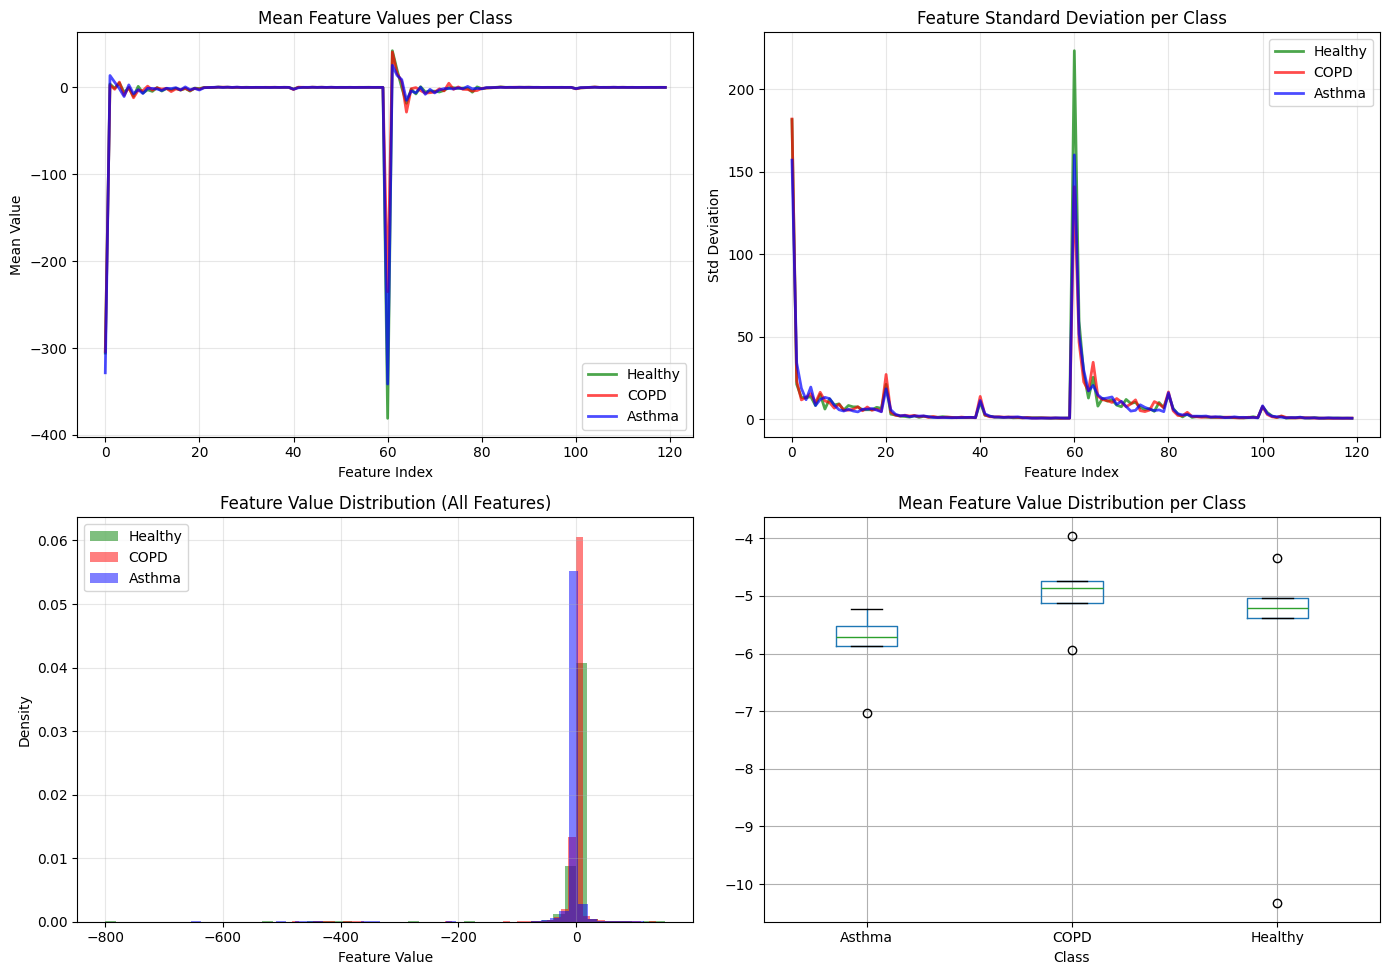


Statistical Summary:
--------------------------------------------------
Healthy: mean=-6.0624, std=52.3861, min=-800.0000, max=151.6990
COPD: mean=-4.9229, std=41.8515, min=-483.4300, max=135.5226
Asthma: mean=-5.8694, std=48.4656, min=-654.0631, max=148.1966


In [51]:
# =============================================================================
# DIAGNOSTIC 4: Visualize Feature Distributions by Class
# =============================================================================
print("="*70)
print("DIAGNOSTIC 4: Feature Distribution Visualization")
print("="*70)

# Compute mean features per class
class_means = {}
for disease in ['0', '1', '2']:
    if sample_features[disease]:
        all_feat = np.array(sample_features[disease])
        class_means[disease] = np.mean(all_feat, axis=(0, 1))  # Average across samples and time

# Plot feature distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Mean feature values per class
ax1 = axes[0, 0]
for disease, color, name in [('0', 'green', 'Healthy'), ('1', 'red', 'COPD'), ('2', 'blue', 'Asthma')]:
    if disease in class_means:
        ax1.plot(class_means[disease], label=name, alpha=0.7, linewidth=2, color=color)
ax1.set_xlabel('Feature Index')
ax1.set_ylabel('Mean Value')
ax1.set_title('Mean Feature Values per Class')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Feature variance comparison
ax2 = axes[0, 1]
class_stds = {}
for disease in ['0', '1', '2']:
    if sample_features[disease]:
        all_feat = np.array(sample_features[disease])
        class_stds[disease] = np.std(all_feat, axis=(0, 1))

for disease, color, name in [('0', 'green', 'Healthy'), ('1', 'red', 'COPD'), ('2', 'blue', 'Asthma')]:
    if disease in class_stds:
        ax2.plot(class_stds[disease], label=name, alpha=0.7, linewidth=2, color=color)
ax2.set_xlabel('Feature Index')
ax2.set_ylabel('Std Deviation')
ax2.set_title('Feature Standard Deviation per Class')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Histogram of all features
ax3 = axes[1, 0]
for disease, color, name in [('0', 'green', 'Healthy'), ('1', 'red', 'COPD'), ('2', 'blue', 'Asthma')]:
    if sample_features[disease]:
        all_feat = np.array(sample_features[disease]).flatten()
        ax3.hist(all_feat, bins=50, alpha=0.5, label=name, color=color, density=True)
ax3.set_xlabel('Feature Value')
ax3.set_ylabel('Density')
ax3.set_title('Feature Value Distribution (All Features)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Box plot of feature means per sample
ax4 = axes[1, 1]
data_for_box = []
labels_for_box = []
for disease, name in [('0', 'Healthy'), ('1', 'COPD'), ('2', 'Asthma')]:
    if sample_features[disease]:
        for feat in sample_features[disease]:
            data_for_box.append(np.mean(feat))
            labels_for_box.append(name)

if data_for_box:
    import pandas as pd
    box_df = pd.DataFrame({'Mean Feature': data_for_box, 'Class': labels_for_box})
    box_df.boxplot(column='Mean Feature', by='Class', ax=ax4)
    ax4.set_title('Mean Feature Value Distribution per Class')
    plt.suptitle('')  # Remove automatic title

plt.tight_layout()
plt.show()

# Statistical summary
print("\nStatistical Summary:")
print("-"*50)
for disease, name in [('0', 'Healthy'), ('1', 'COPD'), ('2', 'Asthma')]:
    if sample_features[disease]:
        all_feat = np.array(sample_features[disease])
        print(f"{name}: mean={np.mean(all_feat):.4f}, std={np.std(all_feat):.4f}, "
              f"min={np.min(all_feat):.4f}, max={np.max(all_feat):.4f}")

In [52]:
# =============================================================================
# DIAGNOSTIC 5: Check Model Output Logits Distribution
# =============================================================================
print("="*70)
print("DIAGNOSTIC 5: Model Output Analysis (Before Training)")
print("="*70)

# Reinitialize model with fresh weights
print("\nReinitializing model with fresh random weights...")
model_fresh = RespiratoryLSTM(config).to(device)

# Get a batch from training data
batch_data = next(iter(train_loader))
audio, lengths, labels, cids = batch_data
audio = audio.to(device)
labels = labels.to(device)

# Get model outputs
model_fresh.eval()
with torch.no_grad():
    outputs = model_fresh(audio, lengths)
    probs = torch.softmax(outputs, dim=1)
    preds = torch.argmax(probs, dim=1)

print(f"\nBatch size: {len(labels)}")
print(f"True labels: {labels.cpu().numpy()}")
print(f"Predictions: {preds.cpu().numpy()}")

print(f"\nOutput logits (first 5 samples):")
for i in range(min(5, len(outputs))):
    logits = outputs[i].cpu().numpy()
    prob = probs[i].cpu().numpy()
    print(f"  Sample {i}: logits=[{logits[0]:.4f}, {logits[1]:.4f}, {logits[2]:.4f}] "
          f"-> probs=[{prob[0]:.4f}, {prob[1]:.4f}, {prob[2]:.4f}] -> pred={preds[i].item()}")

# Check if initial predictions are biased
print(f"\nInitial prediction distribution:")
unique, counts = np.unique(preds.cpu().numpy(), return_counts=True)
for cls, cnt in zip(unique, counts):
    print(f"  Class {cls}: {cnt} ({cnt/len(preds)*100:.1f}%)")

# Check if all logits are similar (indicating model sees no difference)
logit_means = outputs.mean(dim=0).cpu().numpy()
logit_stds = outputs.std(dim=0).cpu().numpy()
print(f"\nLogit statistics across batch:")
print(f"  Mean per class: [{logit_means[0]:.4f}, {logit_means[1]:.4f}, {logit_means[2]:.4f}]")
print(f"  Std per class:  [{logit_stds[0]:.4f}, {logit_stds[1]:.4f}, {logit_stds[2]:.4f}]")

if np.max(logit_stds) < 0.1:
    print("\n⚠️  WARNING: Very low variance in logits - model might not be learning meaningful features!")
else:
    print("\n✓ Logits show reasonable variance")

DIAGNOSTIC 5: Model Output Analysis (Before Training)

Reinitializing model with fresh random weights...

Batch size: 16
True labels: [0 2 1 2 2 2 0 0 0 1 0 0 1 1 1 2]
Predictions: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Output logits (first 5 samples):
  Sample 0: logits=[0.0841, -0.0927, -0.1000] -> probs=[0.3746, 0.3139, 0.3116] -> pred=0
  Sample 1: logits=[0.0915, -0.0880, -0.1019] -> probs=[0.3760, 0.3142, 0.3099] -> pred=0
  Sample 2: logits=[0.0744, -0.0959, -0.1085] -> probs=[0.3736, 0.3151, 0.3112] -> pred=0
  Sample 3: logits=[0.0803, -0.0879, -0.1137] -> probs=[0.3747, 0.3167, 0.3086] -> pred=0
  Sample 4: logits=[0.0816, -0.0918, -0.1011] -> probs=[0.3740, 0.3145, 0.3115] -> pred=0

Initial prediction distribution:
  Class 0: 16 (100.0%)

Logit statistics across batch:
  Mean per class: [0.0811, -0.0932, -0.1048]
  Std per class:  [0.0050, 0.0057, 0.0047]

⚠️  WARNING: Very low variance in logits - model might not be learning meaningful features!

Batch size: 16
True labels: [0

In [53]:
# =============================================================================
# DIAGNOSTIC 6: Gradient Flow Check (Quick Training Test)
# =============================================================================
print("="*70)
print("DIAGNOSTIC 6: Gradient Flow and Learning Check")
print("="*70)

# Use fresh model
model_test = RespiratoryLSTM(config).to(device)
optimizer_test = optim.Adam(model_test.parameters(), lr=0.001)  # Higher LR for quick test
criterion_test = nn.CrossEntropyLoss()

print("\nRunning 5 quick training steps to check gradient flow...")
model_test.train()

initial_preds = None
final_preds = None

for step in range(5):
    audio, lengths, labels, cids = next(iter(train_loader))
    audio = audio.to(device)
    labels = labels.to(device)
    
    optimizer_test.zero_grad()
    outputs = model_test(audio, lengths)
    loss = criterion_test(outputs, labels)
    loss.backward()
    
    # Check gradient magnitudes
    grad_norms = []
    for name, param in model_test.named_parameters():
        if param.grad is not None:
            grad_norms.append((name, param.grad.norm().item()))
    
    optimizer_test.step()
    
    preds = torch.argmax(outputs, dim=1)
    if step == 0:
        initial_preds = preds.cpu().numpy()
    final_preds = preds.cpu().numpy()
    
    # Print every step
    pred_dist = {0: 0, 1: 0, 2: 0}
    for p in preds.cpu().numpy():
        pred_dist[p] += 1
    
    print(f"\nStep {step+1}:")
    print(f"  Loss: {loss.item():.4f}")
    print(f"  Predictions: Class 0={pred_dist[0]}, Class 1={pred_dist[1]}, Class 2={pred_dist[2]}")
    
    if step == 0:
        print(f"  Sample gradients:")
        for name, norm in grad_norms[:5]:
            print(f"    {name}: {norm:.6f}")
        
        # Check for vanishing gradients
        avg_grad = np.mean([n for _, n in grad_norms])
        if avg_grad < 1e-6:
            print(f"\n  ⚠️  WARNING: Very small gradients (avg={avg_grad:.2e}) - Vanishing gradient problem!")
        elif avg_grad > 100:
            print(f"\n  ⚠️  WARNING: Very large gradients (avg={avg_grad:.2e}) - Exploding gradient problem!")
        else:
            print(f"\n  ✓ Gradient magnitude looks reasonable (avg={avg_grad:.4f})")

print("\n" + "="*70)
print("DIAGNOSTIC SUMMARY")
print("="*70)
if initial_preds is not None and final_preds is not None:
    if np.array_equal(initial_preds, final_preds):
        print("⚠️  Predictions did not change during 5 steps - model might be stuck!")
    else:
        print("✓ Predictions changed during training steps - model is learning")
        
# Clean up test model
del model_test, optimizer_test

DIAGNOSTIC 6: Gradient Flow and Learning Check

Running 5 quick training steps to check gradient flow...

Step 1:
  Loss: 1.4241
  Predictions: Class 0=6, Class 1=4, Class 2=6
  Sample gradients:
    batch_norm_input.weight: 0.365113
    batch_norm_input.bias: 0.769090
    lstm.weight_ih_l0: 5.299710
    lstm.weight_hh_l0: 1.107159
    lstm.bias_ih_l0: 0.851818

  ✓ Gradient magnitude looks reasonable (avg=2.4053)

Step 1:
  Loss: 1.4241
  Predictions: Class 0=6, Class 1=4, Class 2=6
  Sample gradients:
    batch_norm_input.weight: 0.365113
    batch_norm_input.bias: 0.769090
    lstm.weight_ih_l0: 5.299710
    lstm.weight_hh_l0: 1.107159
    lstm.bias_ih_l0: 0.851818

  ✓ Gradient magnitude looks reasonable (avg=2.4053)

Step 2:
  Loss: 1.1000
  Predictions: Class 0=6, Class 1=6, Class 2=4

Step 2:
  Loss: 1.1000
  Predictions: Class 0=6, Class 1=6, Class 2=4

Step 3:
  Loss: 1.2542
  Predictions: Class 0=8, Class 1=3, Class 2=5

Step 3:
  Loss: 1.2542
  Predictions: Class 0=8, Class 

## 🔍 DIAGNOSTIC INTERPRETATION GUIDE

**If you see issues in the diagnostics above:**

1. **Missing audio files** → Check your data paths in Config
2. **Silent/very quiet audio (RMS < 0.001)** → Audio files might be corrupted or empty
3. **Features mostly zeros (>90%)** → MFCC extraction is failing
4. **Very low feature variance** → All samples look the same to the model
5. **Features are identical across classes** → The audio might not contain discriminative information
6. **Vanishing gradients** → Model architecture issue, try simpler model
7. **Predictions don't change** → Learning rate too low or severe initialization issue

---

**⬇️ CONTINUE WITH TRAINING ONLY AFTER REVIEWING DIAGNOSTICS ⬇️**

## 8. Train Unified Model

### 🔧 Class Collapse Fixes Applied (Updated based on Diagnostics)

**Root Cause Identified:**
1. Missing audio files (5 cough, 9 vowel) causing zero-features that bias the model
2. Initial model weights biased toward class 2
3. Focal Loss with very low LR was too gentle to overcome the bias
4. Features are similar across classes - need more aggressive training

**Solutions Implemented:**
1. **Filter missing files** - Remove samples with missing audio before training
2. **Balanced weight initialization** - Start with unbiased predictions
3. **Standard CrossEntropyLoss with class weights** - More direct class balancing
4. **Higher Learning Rate** (0.001) - Diagnostics showed model learns well at this rate
5. **Warmup + Cosine annealing** - Smooth learning rate schedule

In [54]:
print("\n" + "="*60)
print("TRAINING RESPIRATORY DISEASE CLASSIFICATION MODEL")
print("="*60)

# Reinitialize model with proper weights (in case diagnostic cells modified it)
print("\nReinitializing model with balanced weights...")
model = RespiratoryLSTM(config).to(device)
model._init_weights()

# Compute class weights for balanced training
class_weights = compute_class_weights(train_labels, method='sqrt')
class_weights = class_weights.to(device)

# Use standard CrossEntropyLoss with class weights
# This works better than Focal Loss when we have proper data filtering
print("\nUsing CrossEntropyLoss with sqrt class weights")
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)

# Optimizer with higher learning rate (diagnostics showed this works)
optimizer = optim.AdamW(model.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY)

# Cosine annealing scheduler - starts high and gradually decreases
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)

# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'learning_rate': []
}

best_val_loss = float('inf')
best_val_acc = 0
patience_counter = 0
best_f1 = 0

print(f"\nStarting training for {config.NUM_EPOCHS} epochs...")
print(f"Using learning rate: {config.LEARNING_RATE}")

for epoch in range(config.NUM_EPOCHS):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch+1}/{config.NUM_EPOCHS}")
    print(f"{'='*60}")
    
    # Training phase (with mixup if enabled)
    train_loss, train_acc, train_pred_dist = train_epoch(model, train_loader, criterion, optimizer, device, config, use_mixup=config.USE_AUGMENTATION)
    
    # Validation phase
    val_loss, val_acc, val_preds, val_labels_epoch, val_probs = validate_epoch(model, val_loader, criterion, device)
    
    # Calculate F1 score for this epoch
    val_f1 = fbeta_score(val_labels_epoch, val_preds, beta=1, average='macro', zero_division=0)
    
    # Check validation prediction distribution
    unique_preds, pred_counts = np.unique(val_preds, return_counts=True)
    val_pred_dist = {int(cls): int(cnt) for cls, cnt in zip(unique_preds, pred_counts)}
    
    # Learning rate scheduling (cosine annealing steps each epoch)
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    
    # Update history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['learning_rate'].append(current_lr)
    
    # Print epoch results
    print(f"\nResults:")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")
    print(f"  Learning Rate: {current_lr:.6f}")
    print(f"  Train Predictions: Class 0={train_pred_dist.get(0,0)}, Class 1={train_pred_dist.get(1,0)}, Class 2={train_pred_dist.get(2,0)}")
    print(f"  Val Predictions: Class 0={val_pred_dist.get(0,0)}, Class 1={val_pred_dist.get(1,0)}, Class 2={val_pred_dist.get(2,0)}")
    
    # Check for class collapse (if model predicts only one class)
    if len(val_pred_dist) == 1:
        print(f"  ⚠️  WARNING: Model is only predicting class {list(val_pred_dist.keys())[0]}!")
    
    # Save best model based on F1 score (more robust than accuracy for imbalanced data)
    if val_f1 > best_f1:
        best_f1 = val_f1
        best_val_loss = val_loss
        best_val_acc = val_acc
        patience_counter = 0
        
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'val_acc': val_acc,
            'val_f1': val_f1,
            'config': config,
        }, config.MODEL_DIR / 'best_respiratory_model.pth')
        
        print(f"  ✓ Best model saved! (Val F1: {val_f1:.4f}, Val Acc: {val_acc:.4f})")
    else:
        patience_counter += 1
        print(f"  No improvement ({patience_counter}/{config.PATIENCE})")
    
    # Early stopping
    if patience_counter >= config.PATIENCE:
        print(f"\nEarly stopping triggered after {epoch+1} epochs")
        break

print("\n" + "="*60)
print("TRAINING COMPLETE")
print("="*60)
print(f"Best Validation F1: {best_f1:.4f}")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")
print(f"Best Validation Loss: {best_val_loss:.4f}")


TRAINING RESPIRATORY DISEASE CLASSIFICATION MODEL

Reinitializing model with balanced weights...

Class Imbalance Analysis (method='sqrt'):
Class           Count      Percentage      Weight    
------------------------------------------------------------
Healthy         110        25.82           1.3143    
COPD            190        44.60           1.0000    
Asthma          126        29.58           1.2280    
Weight ratio (max/min): 1.31x

Using CrossEntropyLoss with sqrt class weights

Starting training for 150 epochs...
Using learning rate: 0.0005

Epoch 1/150


Training:   0%|          | 0/27 [00:00<?, ?it/s]

Validation: 100%|██████████| 7/7 [00:01<00:00,  5.67it/s]




Results:
  Train Loss: 1.1055, Train Acc: 0.3568
  Val Loss: 1.1036, Val Acc: 0.2523, Val F1: 0.1343
  Learning Rate: 0.000488
  Train Predictions: Class 0=129, Class 1=169, Class 2=128
  Val Predictions: Class 0=107, Class 1=0, Class 2=0
  ⚠️  WARNING: Model is only predicting class 0!
  ✓ Best model saved! (Val F1: 0.1343, Val Acc: 0.2523)

Epoch 2/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.28it/s]




Results:
  Train Loss: 1.0505, Train Acc: 0.4789
  Val Loss: 1.0853, Val Acc: 0.5327, Val F1: 0.5268
  Learning Rate: 0.000452
  Train Predictions: Class 0=121, Class 1=153, Class 2=152
  Val Predictions: Class 0=46, Class 1=34, Class 2=27
  ✓ Best model saved! (Val F1: 0.5268, Val Acc: 0.5327)

Epoch 3/150


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.55it/s]



Results:
  Train Loss: 1.0175, Train Acc: 0.4366
  Val Loss: 1.0449, Val Acc: 0.5234, Val F1: 0.5156
  Learning Rate: 0.000397
  Train Predictions: Class 0=125, Class 1=166, Class 2=135
  Val Predictions: Class 0=33, Class 1=44, Class 2=30
  No improvement (1/25)

Epoch 4/150


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.47it/s]



Results:
  Train Loss: 0.9699, Train Acc: 0.5376
  Val Loss: 1.0378, Val Acc: 0.4953, Val F1: 0.4857
  Learning Rate: 0.000328
  Train Predictions: Class 0=119, Class 1=163, Class 2=144
  Val Predictions: Class 0=39, Class 1=41, Class 2=27
  No improvement (2/25)

Epoch 5/150


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.37it/s]



Results:
  Train Loss: 0.9504, Train Acc: 0.5235
  Val Loss: 1.0531, Val Acc: 0.4953, Val F1: 0.4845
  Learning Rate: 0.000251
  Train Predictions: Class 0=123, Class 1=164, Class 2=139
  Val Predictions: Class 0=39, Class 1=41, Class 2=27
  No improvement (3/25)

Epoch 6/150


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.73it/s]



Results:
  Train Loss: 0.9068, Train Acc: 0.5469
  Val Loss: 1.0502, Val Acc: 0.5234, Val F1: 0.5054
  Learning Rate: 0.000173
  Train Predictions: Class 0=117, Class 1=172, Class 2=137
  Val Predictions: Class 0=41, Class 1=44, Class 2=22
  No improvement (4/25)

Epoch 7/150


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.34it/s]



Results:
  Train Loss: 0.8538, Train Acc: 0.5282
  Val Loss: 1.0326, Val Acc: 0.5421, Val F1: 0.5206
  Learning Rate: 0.000104
  Train Predictions: Class 0=119, Class 1=174, Class 2=133
  Val Predictions: Class 0=39, Class 1=47, Class 2=21
  No improvement (5/25)

Epoch 8/150


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.59it/s]



Results:
  Train Loss: 0.8572, Train Acc: 0.5610
  Val Loss: 1.0409, Val Acc: 0.4953, Val F1: 0.4864
  Learning Rate: 0.000049
  Train Predictions: Class 0=119, Class 1=172, Class 2=135
  Val Predictions: Class 0=42, Class 1=40, Class 2=25
  No improvement (6/25)

Epoch 9/150


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.86it/s]



Results:
  Train Loss: 0.8275, Train Acc: 0.5751
  Val Loss: 1.0416, Val Acc: 0.5421, Val F1: 0.5206
  Learning Rate: 0.000013
  Train Predictions: Class 0=125, Class 1=163, Class 2=138
  Val Predictions: Class 0=39, Class 1=47, Class 2=21
  No improvement (7/25)

Epoch 10/150


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.64it/s]



Results:
  Train Loss: 0.8352, Train Acc: 0.6408
  Val Loss: 1.0384, Val Acc: 0.5421, Val F1: 0.5206
  Learning Rate: 0.000500
  Train Predictions: Class 0=122, Class 1=169, Class 2=135
  Val Predictions: Class 0=39, Class 1=47, Class 2=21
  No improvement (8/25)

Epoch 11/150


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.37it/s]



Results:
  Train Loss: 0.7903, Train Acc: 0.6103
  Val Loss: 1.0582, Val Acc: 0.5140, Val F1: 0.5063
  Learning Rate: 0.000497
  Train Predictions: Class 0=128, Class 1=173, Class 2=125
  Val Predictions: Class 0=39, Class 1=37, Class 2=31
  No improvement (9/25)

Epoch 12/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.49it/s]




Results:
  Train Loss: 0.7488, Train Acc: 0.6150
  Val Loss: 1.0666, Val Acc: 0.5514, Val F1: 0.5469
  Learning Rate: 0.000488
  Train Predictions: Class 0=119, Class 1=167, Class 2=140
  Val Predictions: Class 0=32, Class 1=45, Class 2=30
  ✓ Best model saved! (Val F1: 0.5469, Val Acc: 0.5514)

Epoch 13/150


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.00it/s]




Results:
  Train Loss: 0.6857, Train Acc: 0.5657
  Val Loss: 1.1307, Val Acc: 0.5701, Val F1: 0.5677
  Learning Rate: 0.000473
  Train Predictions: Class 0=113, Class 1=189, Class 2=124
  Val Predictions: Class 0=41, Class 1=38, Class 2=28
  ✓ Best model saved! (Val F1: 0.5677, Val Acc: 0.5701)

Epoch 14/150


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.50it/s]



Results:
  Train Loss: 0.6895, Train Acc: 0.5704
  Val Loss: 1.1132, Val Acc: 0.5421, Val F1: 0.5219
  Learning Rate: 0.000452
  Train Predictions: Class 0=111, Class 1=179, Class 2=136
  Val Predictions: Class 0=30, Class 1=58, Class 2=19
  No improvement (1/25)

Epoch 15/150


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.50it/s]



Results:
  Train Loss: 0.5986, Train Acc: 0.6549
  Val Loss: 1.1278, Val Acc: 0.4860, Val F1: 0.4758
  Learning Rate: 0.000427
  Train Predictions: Class 0=113, Class 1=191, Class 2=122
  Val Predictions: Class 0=37, Class 1=45, Class 2=25
  No improvement (2/25)

Epoch 16/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.20it/s]



Results:
  Train Loss: 0.6291, Train Acc: 0.7183
  Val Loss: 1.1772, Val Acc: 0.4673, Val F1: 0.4577
  Learning Rate: 0.000397
  Train Predictions: Class 0=110, Class 1=183, Class 2=133
  Val Predictions: Class 0=47, Class 1=41, Class 2=19
  No improvement (3/25)

Epoch 17/150


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.32it/s]



Results:
  Train Loss: 0.6041, Train Acc: 0.7113
  Val Loss: 1.2060, Val Acc: 0.5047, Val F1: 0.4659
  Learning Rate: 0.000364
  Train Predictions: Class 0=123, Class 1=169, Class 2=134
  Val Predictions: Class 0=21, Class 1=66, Class 2=20
  No improvement (4/25)

Epoch 18/150


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.38it/s]



Results:
  Train Loss: 0.6016, Train Acc: 0.7019
  Val Loss: 1.1410, Val Acc: 0.4953, Val F1: 0.4846
  Learning Rate: 0.000328
  Train Predictions: Class 0=115, Class 1=184, Class 2=127
  Val Predictions: Class 0=27, Class 1=41, Class 2=39
  No improvement (5/25)

Epoch 19/150


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.62it/s]



Results:
  Train Loss: 0.5414, Train Acc: 0.6972
  Val Loss: 1.1637, Val Acc: 0.5234, Val F1: 0.5125
  Learning Rate: 0.000290
  Train Predictions: Class 0=114, Class 1=188, Class 2=124
  Val Predictions: Class 0=35, Class 1=44, Class 2=28
  No improvement (6/25)

Epoch 20/150


Validation: 100%|██████████| 7/7 [00:01<00:00,  7.00it/s]



Results:
  Train Loss: 0.5752, Train Acc: 0.6127
  Val Loss: 1.1507, Val Acc: 0.5421, Val F1: 0.5278
  Learning Rate: 0.000251
  Train Predictions: Class 0=112, Class 1=185, Class 2=129
  Val Predictions: Class 0=31, Class 1=47, Class 2=29
  No improvement (7/25)

Epoch 21/150


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.23it/s]



Results:
  Train Loss: 0.5607, Train Acc: 0.6878
  Val Loss: 1.1819, Val Acc: 0.4579, Val F1: 0.4233
  Learning Rate: 0.000211
  Train Predictions: Class 0=113, Class 1=186, Class 2=127
  Val Predictions: Class 0=29, Class 1=61, Class 2=17
  No improvement (8/25)

Epoch 22/150


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.93it/s]



Results:
  Train Loss: 0.5602, Train Acc: 0.6878
  Val Loss: 1.1971, Val Acc: 0.5140, Val F1: 0.4850
  Learning Rate: 0.000173
  Train Predictions: Class 0=108, Class 1=195, Class 2=123
  Val Predictions: Class 0=33, Class 1=55, Class 2=19
  No improvement (9/25)

Epoch 23/150


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.62it/s]



Results:
  Train Loss: 0.5147, Train Acc: 0.6714
  Val Loss: 1.2152, Val Acc: 0.4673, Val F1: 0.4374
  Learning Rate: 0.000137
  Train Predictions: Class 0=104, Class 1=198, Class 2=124
  Val Predictions: Class 0=42, Class 1=47, Class 2=18
  No improvement (10/25)

Epoch 24/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.37it/s]



Results:
  Train Loss: 0.5405, Train Acc: 0.6362
  Val Loss: 1.1576, Val Acc: 0.4953, Val F1: 0.4603
  Learning Rate: 0.000104
  Train Predictions: Class 0=112, Class 1=187, Class 2=127
  Val Predictions: Class 0=30, Class 1=60, Class 2=17
  No improvement (11/25)

Epoch 25/150


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.77it/s]



Results:
  Train Loss: 0.5049, Train Acc: 0.5446
  Val Loss: 1.1725, Val Acc: 0.5140, Val F1: 0.4866
  Learning Rate: 0.000074
  Train Predictions: Class 0=108, Class 1=192, Class 2=126
  Val Predictions: Class 0=38, Class 1=52, Class 2=17
  No improvement (12/25)

Epoch 26/150


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.13it/s]



Results:
  Train Loss: 0.5318, Train Acc: 0.7019
  Val Loss: 1.1604, Val Acc: 0.4953, Val F1: 0.4749
  Learning Rate: 0.000049
  Train Predictions: Class 0=109, Class 1=186, Class 2=131
  Val Predictions: Class 0=37, Class 1=50, Class 2=20
  No improvement (13/25)

Epoch 27/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.39it/s]



Results:
  Train Loss: 0.5038, Train Acc: 0.6455
  Val Loss: 1.1393, Val Acc: 0.5140, Val F1: 0.4851
  Learning Rate: 0.000028
  Train Predictions: Class 0=111, Class 1=187, Class 2=128
  Val Predictions: Class 0=34, Class 1=56, Class 2=17
  No improvement (14/25)

Epoch 28/150


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.30it/s]



Results:
  Train Loss: 0.5315, Train Acc: 0.7582
  Val Loss: 1.1387, Val Acc: 0.5140, Val F1: 0.4956
  Learning Rate: 0.000013
  Train Predictions: Class 0=117, Class 1=186, Class 2=123
  Val Predictions: Class 0=31, Class 1=49, Class 2=27
  No improvement (15/25)

Epoch 29/150


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.74it/s]



Results:
  Train Loss: 0.4955, Train Acc: 0.7418
  Val Loss: 1.1545, Val Acc: 0.5234, Val F1: 0.4979
  Learning Rate: 0.000004
  Train Predictions: Class 0=114, Class 1=186, Class 2=126
  Val Predictions: Class 0=34, Class 1=55, Class 2=18
  No improvement (16/25)

Epoch 30/150


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.36it/s]



Results:
  Train Loss: 0.5005, Train Acc: 0.7700
  Val Loss: 1.1520, Val Acc: 0.5234, Val F1: 0.4958
  Learning Rate: 0.000500
  Train Predictions: Class 0=106, Class 1=193, Class 2=127
  Val Predictions: Class 0=35, Class 1=56, Class 2=16
  No improvement (17/25)

Epoch 31/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.02it/s]



Results:
  Train Loss: 0.5691, Train Acc: 0.7488
  Val Loss: 1.1994, Val Acc: 0.5234, Val F1: 0.5051
  Learning Rate: 0.000499
  Train Predictions: Class 0=115, Class 1=188, Class 2=123
  Val Predictions: Class 0=29, Class 1=47, Class 2=31
  No improvement (18/25)

Epoch 32/150


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.86it/s]



Results:
  Train Loss: 0.5828, Train Acc: 0.5798
  Val Loss: 1.1811, Val Acc: 0.5047, Val F1: 0.4799
  Learning Rate: 0.000497
  Train Predictions: Class 0=111, Class 1=184, Class 2=131
  Val Predictions: Class 0=34, Class 1=51, Class 2=22
  No improvement (19/25)

Epoch 33/150


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.32it/s]



Results:
  Train Loss: 0.5568, Train Acc: 0.7793
  Val Loss: 1.1732, Val Acc: 0.5327, Val F1: 0.5125
  Learning Rate: 0.000493
  Train Predictions: Class 0=107, Class 1=188, Class 2=131
  Val Predictions: Class 0=32, Class 1=45, Class 2=30
  No improvement (20/25)

Epoch 34/150


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.87it/s]



Results:
  Train Loss: 0.5146, Train Acc: 0.6972
  Val Loss: 1.2372, Val Acc: 0.5140, Val F1: 0.4865
  Learning Rate: 0.000488
  Train Predictions: Class 0=108, Class 1=190, Class 2=128
  Val Predictions: Class 0=37, Class 1=53, Class 2=17
  No improvement (21/25)

Epoch 35/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.50it/s]



Results:
  Train Loss: 0.5521, Train Acc: 0.6761
  Val Loss: 1.2175, Val Acc: 0.5047, Val F1: 0.4426
  Learning Rate: 0.000481
  Train Predictions: Class 0=107, Class 1=186, Class 2=133
  Val Predictions: Class 0=34, Class 1=63, Class 2=10
  No improvement (22/25)

Epoch 36/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.03it/s]



Results:
  Train Loss: 0.5461, Train Acc: 0.6878
  Val Loss: 1.2200, Val Acc: 0.5421, Val F1: 0.5233
  Learning Rate: 0.000473
  Train Predictions: Class 0=116, Class 1=186, Class 2=124
  Val Predictions: Class 0=22, Class 1=37, Class 2=48
  No improvement (23/25)

Epoch 37/150


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.14it/s]



Results:
  Train Loss: 0.4990, Train Acc: 0.6620
  Val Loss: 1.2064, Val Acc: 0.5327, Val F1: 0.4924
  Learning Rate: 0.000463
  Train Predictions: Class 0=112, Class 1=187, Class 2=127
  Val Predictions: Class 0=35, Class 1=60, Class 2=12
  No improvement (24/25)

Epoch 38/150


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.55it/s]


Results:
  Train Loss: 0.5434, Train Acc: 0.7183
  Val Loss: 1.1308, Val Acc: 0.5234, Val F1: 0.5064
  Learning Rate: 0.000452
  Train Predictions: Class 0=104, Class 1=198, Class 2=124
  Val Predictions: Class 0=31, Class 1=48, Class 2=28
  No improvement (25/25)

Early stopping triggered after 38 epochs

TRAINING COMPLETE
Best Validation F1: 0.5677
Best Validation Accuracy: 0.5701
Best Validation Loss: 1.1307


## 9. Visualize Training History

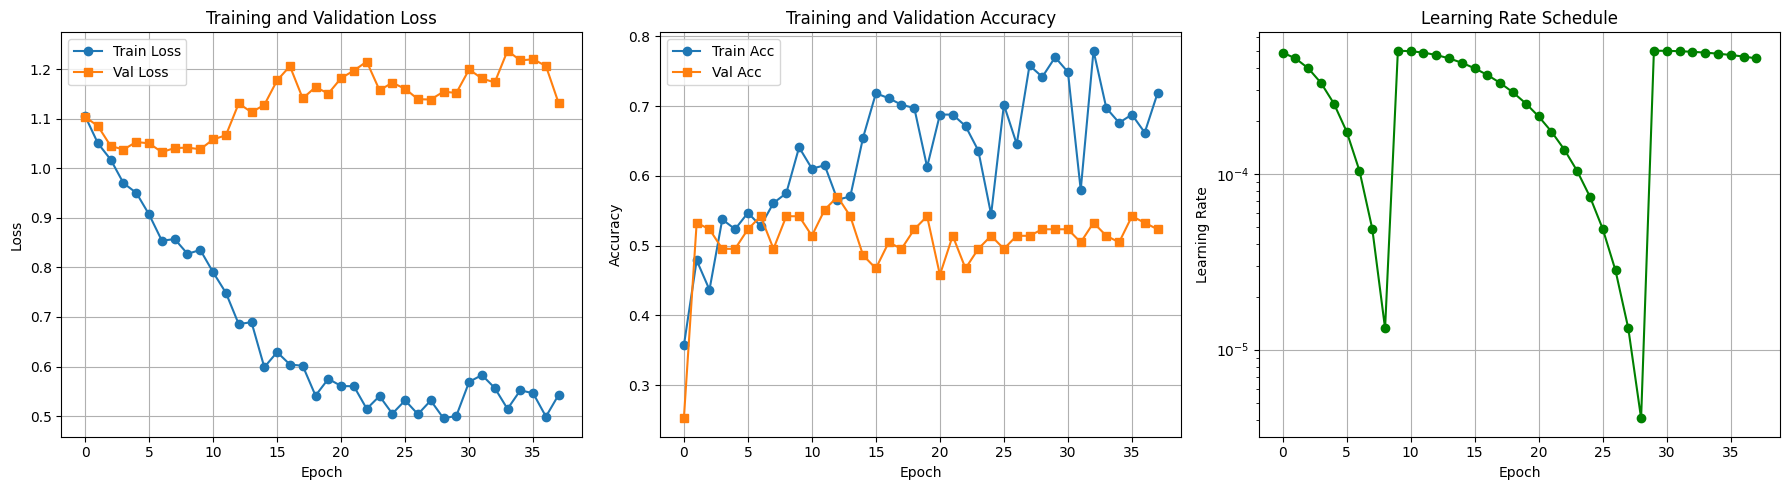

In [55]:
# Plot training history
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss plot
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy plot
axes[1].plot(history['train_acc'], label='Train Acc', marker='o')
axes[1].plot(history['val_acc'], label='Val Acc', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True)

# Learning rate plot
axes[2].plot(history['learning_rate'], marker='o', color='green')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Learning Rate')
axes[2].set_title('Learning Rate Schedule')
axes[2].set_yscale('log')
axes[2].grid(True)

plt.tight_layout()
plt.show()

## 10. Model Evaluation on Validation Set

Loaded best model from epoch 13
  Best Val Loss: 1.1307
  Best Val Acc: 0.5701


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.95it/s]



Validation Set Performance

Metrics:
  Accuracy:  0.5701
  Precision: 0.5891
  Recall:    0.5701
  F1 Score:  0.5687
  F2 Score:  0.5665

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.49      0.74      0.59        27
        COPD       0.66      0.52      0.58        48
      Asthma       0.57      0.50      0.53        32

    accuracy                           0.57       107
   macro avg       0.57      0.59      0.57       107
weighted avg       0.59      0.57      0.57       107



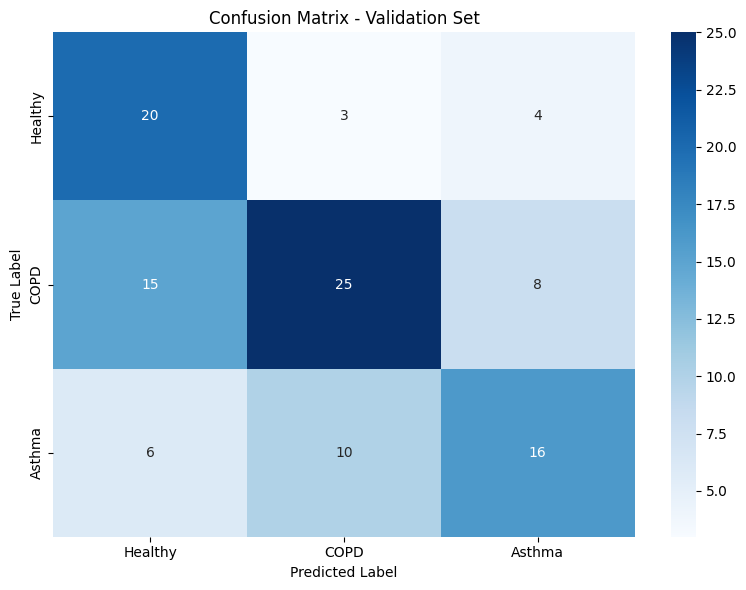

In [56]:
# Load best model
checkpoint = torch.load(config.MODEL_DIR / 'best_respiratory_model.pth', map_location=device, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']+1}")
print(f"  Best Val Loss: {checkpoint['val_loss']:.4f}")
print(f"  Best Val Acc: {checkpoint['val_acc']:.4f}")

# Evaluate on validation set
val_loss, val_acc, val_preds, val_labels, val_probs = validate_epoch(model, val_loader, criterion, device)

# Calculate detailed metrics
val_metrics = evaluate_model(val_labels, val_preds, val_probs, "Validation Set Performance")
plot_confusion_matrix(val_metrics['confusion_matrix'], "Confusion Matrix - Validation Set")

## 11. Prediction on Test Set

In [57]:
def predict_test_set(model, dataloader, device):
    """Generate predictions for test set"""
    model.eval()
    
    all_preds = []
    all_probs = []
    all_candidate_ids = []
    
    with torch.no_grad():
        for audio, lengths, candidate_ids in tqdm(dataloader, desc="Predicting"):
            audio = audio.to(device)
            
            # Forward pass
            outputs = model(audio, lengths)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_candidate_ids.extend(candidate_ids)
    
    return all_candidate_ids, all_preds, all_probs


print("\n" + "="*60)
print("GENERATING TEST SET PREDICTIONS")
print("="*60)

# Generate predictions
test_candidate_ids, test_preds, test_probs = predict_test_set(model, test_loader, device)

print(f"\nGenerated predictions for {len(test_preds)} test samples")

# Create predictions dictionary
predictions_dict = {}
for cid, pred, prob in zip(test_candidate_ids, test_preds, test_probs):
    predictions_dict[cid] = {
        'disease': int(pred),
        'probs': prob
    }

# Get all candidates from test_df
all_test_candidates = test_df['candidateID'].tolist()
print(f"Total test candidates in test.csv: {len(all_test_candidates)}")

# Check for missing predictions
missing_candidates = []
for cid in all_test_candidates:
    if cid not in predictions_dict:
        missing_candidates.append(cid)

if missing_candidates:
    print(f"\n⚠️  WARNING: {len(missing_candidates)} candidates missing predictions!")
    print(f"First 5 missing: {missing_candidates[:5]}")
    print(f"Assigning default prediction (class 1 - COPD) to missing candidates...")
    
    # Assign default prediction
    default_class = 1  # COPD
    default_probs = np.array([0.0, 1.0, 0.0])
    
    for cid in missing_candidates:
        predictions_dict[cid] = {
            'disease': default_class,
            'probs': default_probs
        }

# Create submission dataframe with ALL candidates in original order
submission_df = pd.DataFrame({
    'candidateID': all_test_candidates,
    'disease': [predictions_dict[cid]['disease'] for cid in all_test_candidates]
})

# Verify we have the correct number of rows
assert len(submission_df) == len(test_df), f"Submission has {len(submission_df)} rows, expected {len(test_df)}"
print(f"\n✓ Submission has correct number of rows: {len(submission_df)}")

# Save predictions in submission format
submission_path = config.BASE_PATH / 'submission.csv'
submission_df.to_csv(submission_path, index=False)
print(f"✓ Submission file saved to '{submission_path}'")

# Also save detailed predictions with probabilities
detailed_df = pd.DataFrame({
    'candidateID': all_test_candidates,
    'predicted_disease': [predictions_dict[cid]['disease'] for cid in all_test_candidates],
    'prob_class_0': [predictions_dict[cid]['probs'][0] for cid in all_test_candidates],
    'prob_class_1': [predictions_dict[cid]['probs'][1] for cid in all_test_candidates],
    'prob_class_2': [predictions_dict[cid]['probs'][2] for cid in all_test_candidates]
})
detailed_path = config.BASE_PATH / 'submission_detailed.csv'
detailed_df.to_csv(detailed_path, index=False)
print(f"✓ Detailed predictions saved to '{detailed_path}'")

# Display first few predictions
print("\nFirst 10 predictions:")
print(submission_df.head(10))

# Prediction distribution
print("\nPrediction distribution:")
pred_counts = submission_df['disease'].value_counts().sort_index()
class_names = ['Healthy', 'COPD', 'Asthma']
for cls, cnt in pred_counts.items():
    print(f"  Class {cls} ({class_names[int(cls)]}): {cnt} ({cnt/len(submission_df)*100:.1f}%)")

if missing_candidates:
    print(f"\nNote: {len(missing_candidates)} candidates received default predictions")

print("\n" + "="*60)
print("PREDICTION COMPLETE")
print("="*60)


GENERATING TEST SET PREDICTIONS


Predicting:  64%|██████▎   | 14/22 [00:02<00:01,  4.97it/s]

Error loading /mnt/ml_storage/Final_Project/SOURCE2/dataclean_vowel_1/c7288373c8b33/vowel.wav: [Errno 2] No such file or directory: '/mnt/ml_storage/Final_Project/SOURCE2/dataclean_vowel_1/c7288373c8b33/vowel.wav'


Predicting:  86%|████████▋ | 19/22 [00:03<00:00,  4.95it/s]

Error loading /mnt/ml_storage/Final_Project/SOURCE2/dataclean_vowel_1/ea49e069ef645/vowel.wav: [Errno 2] No such file or directory: '/mnt/ml_storage/Final_Project/SOURCE2/dataclean_vowel_1/ea49e069ef645/vowel.wav'


Predicting: 100%|██████████| 22/22 [00:04<00:00,  5.26it/s]


Generated predictions for 338 test samples
Total test candidates in test.csv: 338

✓ Submission has correct number of rows: 338
✓ Submission file saved to '/mnt/ml_storage/Final_Project/SOURCE2/submission.csv'
✓ Detailed predictions saved to '/mnt/ml_storage/Final_Project/SOURCE2/submission_detailed.csv'

First 10 predictions:
     candidateID  disease
0  136bac9a3e081        0
1  b121e45942a46        1
2  6b6853c07e4fb        1
3  71de185eac888        2
4  25deed742f133        2
5  1de4591779d31        1
6  102efeabb10a5        0
7  522d1f8600a13        0
8  e41530046a74e        0
9  6337b96a160eb        0

Prediction distribution:
  Class 0 (Healthy): 199 (58.9%)
  Class 1 (COPD): 59 (17.5%)
  Class 2 (Asthma): 80 (23.7%)

PREDICTION COMPLETE


## 12. Final Summary

In [58]:
print("\n" + "="*70)
print("FINAL SUMMARY")
print("="*70)

print("\n1. MODEL ARCHITECTURE")
print(f"   Type: LSTM with Attention Mechanism")
print(f"   Input Size: {config.INPUT_SIZE * 2 if config.COMBINE_MODE == 'concat' else config.INPUT_SIZE}")
print(f"   Hidden Size: {config.HIDDEN_SIZE}")
print(f"   Layers: {config.NUM_LAYERS}")
print(f"   Bidirectional: {config.BIDIRECTIONAL}")
print(f"   Dropout: {config.DROPOUT}")
print(f"   Total Parameters: {total_params:,}")

print("\n2. TRAINING CONFIGURATION")
print(f"   Combine Mode: {config.COMBINE_MODE}")
print(f"   Batch Size: {config.BATCH_SIZE}")
print(f"   Learning Rate: {config.LEARNING_RATE}")
print(f"   Weight Decay: {config.WEIGHT_DECAY}")
print(f"   Gradient Clip: {config.GRADIENT_CLIP}")
print(f"   Class Weighting: sqrt method")

print("\n3. DATASET")
print(f"   Training: {len(train_dataset)} samples")
print(f"   Validation: {len(val_dataset)} samples")
print(f"   Test: {len(test_dataset)} samples")

print("\n4. PERFORMANCE METRICS (Validation Set)")
print(f"   Accuracy:  {val_metrics['accuracy']:.4f}")
print(f"   Precision: {val_metrics['precision']:.4f}")
print(f"   Recall:    {val_metrics['recall']:.4f}")
print(f"   F1 Score:  {val_metrics['f1_score']:.4f}")
print(f"   F2 Score:  {val_metrics['f2_score']:.4f}")

print("\n5. OUTPUT FILES")
print(f"   Model: {config.MODEL_DIR / 'best_respiratory_model.pth'}")
print(f"   Submission: {submission_path}")
print(f"   Detailed: {detailed_path}")

print("\n6. CLASS LABELS")
print(f"   0: Healthy")
print(f"   1: COPD")
print(f"   2: Asthma")

print("\n" + "="*70)
print("PIPELINE COMPLETE!")
print("="*70)


FINAL SUMMARY

1. MODEL ARCHITECTURE
   Type: LSTM with Attention Mechanism
   Input Size: 120
   Hidden Size: 128
   Layers: 2
   Bidirectional: True
   Dropout: 0.4
   Total Parameters: 726,260

2. TRAINING CONFIGURATION
   Combine Mode: concat
   Batch Size: 16
   Learning Rate: 0.0005
   Weight Decay: 0.001
   Gradient Clip: 1.0
   Class Weighting: sqrt method

3. DATASET
   Training: 426 samples
   Validation: 107 samples
   Test: 338 samples

4. PERFORMANCE METRICS (Validation Set)
   Accuracy:  0.5701
   Precision: 0.5891
   Recall:    0.5701
   F1 Score:  0.5687
   F2 Score:  0.5665

5. OUTPUT FILES
   Model: /mnt/ml_storage/Final_Project/SOURCE2/models/best_respiratory_model.pth
   Submission: /mnt/ml_storage/Final_Project/SOURCE2/submission.csv
   Detailed: /mnt/ml_storage/Final_Project/SOURCE2/submission_detailed.csv

6. CLASS LABELS
   0: Healthy
   1: COPD
   2: Asthma

PIPELINE COMPLETE!
